# Predicting the distribution of $q=1/x$ when $x\sim N(\mu,\sigma)$ with automatic differentiation

by Kyle Cranmer, March 2, 2020

In [1]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt

In [2]:
mean=1.
std = .3
N = 10000

x = np.random.normal(mean, std, N)

In [3]:
x_plot = np.linspace(0.1,3,100)

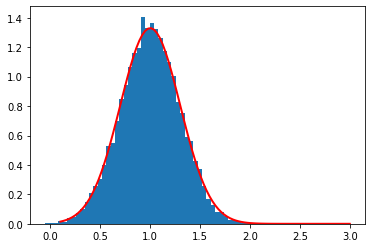

In [4]:
_ = plt.hist(x, bins=50, density=True)
plt.plot(x_plot, scs.norm.pdf(x_plot, mean, std), c='r', lw=2)

In [5]:
def q(x):
    return 1/x

In [6]:
q_ = q(x)
q_plot = q(x_plot)

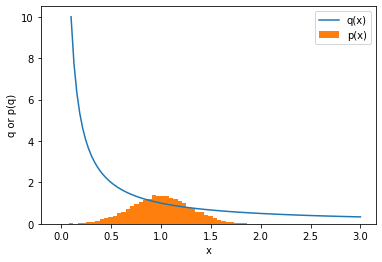

In [7]:
plt.plot(x_plot, q_plot,label='q(x)')
_ = plt.hist(x, bins=50, density=True, label='p(x)')
plt.xlabel('x')
plt.ylabel('q or p(q)')
plt.legend()

Text(0, 0.5, 'p(x)')

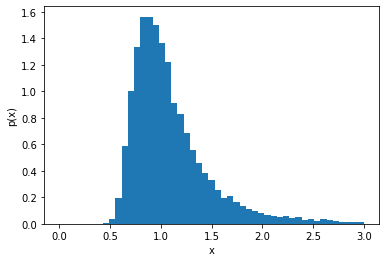

In [8]:
mybins = np.linspace(0,3,50)
_ = plt.hist(q_, bins=mybins, density=True)
plt.xlabel('x')
plt.ylabel('p(x)')

## Do it by hand

We want to evaluate 
$p_q(q) = \frac{p_x(x(q))}{ | dq/dx |} $, 
which requires knowing the deriviative and how to invert from $q \to x$. The inversion is easy, it's just $x(q)=1/q$. The derivative is $dq/dx = \frac{-1}{x^2}$, which in terms of $q$ is $dq/dx = q^2$.

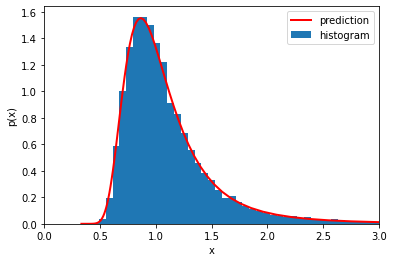

In [9]:
_ = plt.hist(q_, bins=mybins, density=True, label='histogram')
plt.plot(q_plot, scs.norm.pdf(1/q_plot, mean, std)/q_plot/q_plot, c='r', lw=2, label='prediction')
plt.xlim((0,3))
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()

Alternatively, we don't need to know how to invert $x(q)$. Instead, we can start with `x_plot` and use the evaluated pairs `(x_plot, q_plot=q(x_plot))`. Then we can just use `x_plot` when we want $x(q)$.

Here is a plot of the inverse mad ethat way.

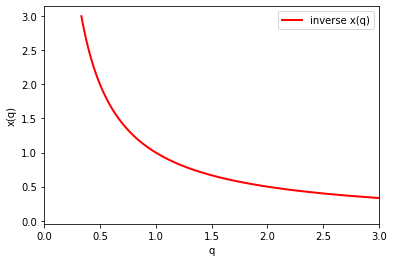

In [10]:
plt.plot(q_plot, x_plot, c='r', lw=2, label='inverse x(q)')
plt.xlim((0,3))
plt.xlabel('q')
plt.ylabel('x(q)')
plt.legend()

and here is a plot of our prediction using `x_plot` directly

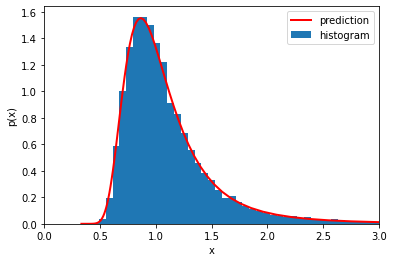

In [11]:
_ = plt.hist(q_, bins=mybins, density=True, label='histogram')
plt.plot(q_plot, scs.norm.pdf(x_plot, mean, std)/np.power(x_plot,-2), c='r', lw=2, label='prediction')
plt.xlim((0,3))
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()

## With Jax Autodiff for the derivatives

Now let's do the same thing using Jax to calculate the derivatives. We will make a new function `dq` by applying the `grad` function of Jax to our own function `q` (eg. `dq = grad(q)`).


In [12]:
from jax import grad, vmap
import jax.numpy as np

In [13]:
#define the gradient with grad(q)
dq = grad(q)  #dq is a new python function
print(dq(.5)) # should be -4

-4.0


/Users/cranmer/anaconda3/envs/stat-ds-book/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [14]:
# dq(x) #broadcasting won't work. Gives error:
# Gradient only defined for scalar-output functions. Output had shape: (10000,).

In [15]:
#define the gradient with grad(q) that works with broadcasting
dq = vmap(grad(q))

In [16]:
#print dq/dx for x=0.5, 1, 2
# it should be -1/x^2 =. -4, 1, -0.25

dq( np.array([.5, 1, 2.]))

DeviceArray([-4.  , -1.  , -0.25], dtype=float32)

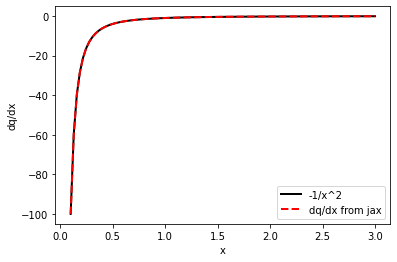

In [17]:
#plot gradient
plt.plot(x_plot, -np.power(x_plot,-2), c='black', lw=2, label='-1/x^2')
plt.plot(x_plot, dq(x_plot), c='r', lw=2, ls='dashed', label='dq/dx from jax')
plt.xlabel('x')
plt.ylabel('dq/dx')
plt.legend()

We want to evaluate 
$p_q(q) = \frac{p_x(x(q))}{ | dq/dx |} $, 
which requires knowing how to invert from $q \to x$. That's easy, it's just $x(q)=1/q$. But we also have evaluated pairs `(x_plot, q_plot)`, so we can just use `x_plot` when we want $x(q)$

Put it all together.

Again we can either invert `x(q)` by hand and use Jax for derivative:

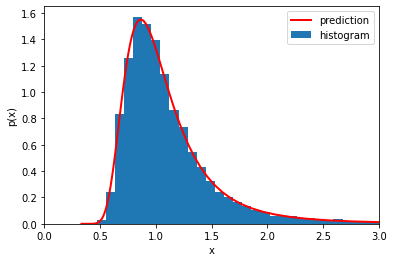

In [18]:
_ = plt.hist(q_, bins=np.linspace(-1,3,50), density=True, label='histogram')
plt.plot(q_plot, scs.norm.pdf(1/q_plot, mean, std)/np.abs(dq(1/q_plot)), c='r', lw=2, label='prediction')
plt.xlim((0,3))
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()

or we can use the pairs `x_plot, q_plot`

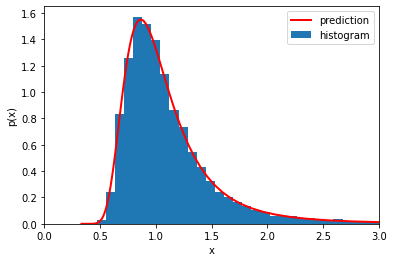

In [19]:
_ = plt.hist(q_, bins=np.linspace(-1,3,50), density=True, label='histogram')
plt.plot(q_plot, scs.norm.pdf(x_plot, mean, std)/np.abs(dq(x_plot)), c='r', lw=2, label='prediction')
plt.xlim((0,3))
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()